### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.inspection import partial_dependence, plot_partial_dependence
from progressbar import ProgressBar
pbar = ProgressBar()

glob_split = 4
global_rand_state_xgb = 4

2023-03-06 12:05:21.744155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 12:05:21.808268: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 12:05:22.119304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-03-06 12:05:22.119348: W tensorflow/compile

In [2]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation_90rem.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [3]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)

In [4]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [5]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

In [6]:
##########!!!!!!!!!!!!!!!!!!!!!!!! I reduced the n_estimators
r_squareds_global = []
list_glob_rand_state = []
start = time.time()
pbar = ProgressBar()
# best split 2571, 2576
repeat = 100
glob_split_list = np.repeat(range(2571, 2576), repeat)
#If_rand_list = np.array (1000*np.round (np.random.rand(1, 5*repeat), 3), int).ravel()
If_rand_list = np.array (1000*np.round (np.random.rand(1, 5*repeat), 3), int).ravel()
Imax_rand_list = np.array (1000*np.round (np.random.rand(1, 5*repeat), 3), int).ravel()
charge_rand_list = np.array (1000*np.round (np.random.rand(1, 5*repeat), 3), int).ravel()

max_depths=[3, 3, 3, 3, 4]
n_estimatorss=[28, 30, 22, 50, 35]
gammas=[0.001, 0.001, 0.001, 0.001, 0.001,] 
learning_rates=[0.099383, 0.099383, 0.099383, 0.099383, 0.099383,] 
subsamples=[0.7746, 0.7746,  0.7746,  0.77,  0.7746, ] 
min_child_weights=[3, 3, 3, 3, 3]

for glob_split, If_rand, Imax_rand, charge_rand in\
                     zip(pbar(glob_split_list), If_rand_list, Imax_rand_list, charge_rand_list):
    #### Materials coef. for 3 time-current properties
    #print ('#### material coef. for 3 current properties')
    ## material coef. Final_Current_Percent
    input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                     Res_Drop, Volt_Drop, Graphene_Yield), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Final_Current_Percent, test_size=0.2, random_state=glob_split)

    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_IfImax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_IfImax: ', pearr[0])

    ## material coef. I_max normalized
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_I_Max, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_Imax: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_Imax: ', pearr[0])

    ## material coef.  Norm_charge_tot
    input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                     Res_Drop, Volt_Drop), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
            input_features, Norm_charge_tot, test_size=0.2, random_state=glob_split)
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0: 4]
    y_pred = clf.predict (X_test)
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r2 mat_chargetot: ', r2)
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r mat_chargetot: ', pearr[0])
    material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
    material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
    material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

    #### proxy XGBoost Final_Current_percent
    new_features = np.concatenate ((charge_denisty, pulsetime,
                                    material_type_I_Finalperc_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                          train_test_split(new_features, Final_Current_Percent, df['Material'],
                                         indices, test_size = 0.20, random_state = glob_split)
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                       learning_rate=0.0994, subsample=0.77, min_child_weight=9, n_jobs=1,
                       random_state=If_rand)

    xgbr_final_I_percent.fit(train_new_features, train_labels)
    Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)  
    y_pred = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, y_pred)
    #print('r2 score = ', r_squared_Final_Current_test)
    pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), y_pred.ravel())
    #print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

    #### proxy XGBoost Norm_I_Max
    new_features = np.concatenate ((charge_denisty,
                                    pulsetime, material_type_Norm_I_Max_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_I_Max, 
                                           indices, test_size = 0.2, random_state = glob_split)  
    xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                       learning_rate=0.09, subsample=0.775, min_child_weight=12, n_jobs=1,
                      random_state=Imax_rand)
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
    #print('r2 score for test = ', r_squared_Norm_I_Max_test)
    pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
    #print('pearson r for test= ', pr_Norm_I_Max_test[0])

    #### proxy XGBoost Norm_Norm_charge_tot
    #print ('#### proxy XGBoost Norm_Norm_charge_tot')
    new_features = np.concatenate ((charge_denisty,pulsetime,
                                    material_type_Norm_charge_Tot_coef,
                                    atmosphere_type, Pretreat_voltage), axis=1)
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                          train_test_split(new_features, Norm_charge_tot, 
                                           indices, test_size = 0.20, random_state = glob_split)
    xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.099395, subsample=0.75, min_child_weight=3, n_jobs=1,
                  random_state=charge_rand)
    xgbr_norm_charge_total.fit(train_new_features, train_labels)
    Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    #print('r2 score for test= ', r_squared_Norm_charge_tot_test)
    pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
    #print('pearson r for test= ', pr_Norm_charge_tot_test[0])

    #### FINAL prediction of Graphene Yield
    CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
    resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
    heat_power = np.array (df['Voltage']*df['Voltage']/(resistance_matrix**1)*df['PulseTime']*(1e-6)).reshape(-1, 1)
    CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                                 CB_MC_PA_coef_Norm_I_Max +
                                 CB_MC_PA_coef_Norm_charge_tot)/3

    material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
    new_features = np.concatenate ((charge_denisty, 
                                    X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                    #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                    #material_type_GY_coef,
                                    pulsetime,
                                    Pretreat_voltage,
                                    np.log(np.array (df['temp2']).reshape(-1, 1)),

                                    atmosphere_type,
                                    Final_Current_Percent_predicted.reshape(-1, 1),
                                    Norm_I_Max_predicted.reshape(-1, 1),
                                    Norm_charge_tot_predicted.reshape(-1, 1), 
                                    heat_power.reshape(-1, 1)), axis=1)
    test_size = 0.2
    indices = np.arange(len(new_features))
    labels = Graphene_Yield
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                          train_test_split(new_features, labels, 
                                           indices, test_size = test_size, random_state=glob_split)
    r_squareds = list()
    r_squareds_randomized_testtrain = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    r2_max = 0
    test_split_seed1 = glob_split
    test_split_seed2 = glob_split + 1
    test_split_count = test_split_seed2 - test_split_seed1
    rep=10
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    # rand = 499 with max of:  0.79
    for random_state in range (499, 500):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=max_depths[glob_split-2571], 
                                       n_estimators=n_estimatorss[glob_split-2571], 
                                       gamma=gammas[glob_split-2571], 
                                       learning_rate=learning_rates[glob_split-2571], 
                                       subsample=subsamples[glob_split-2571],  
                                       min_child_weight=min_child_weights[glob_split-2571], 
                                       n_jobs=1, random_state=random_state)
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        predictions = xgbr_graphyield.predict(test_new_features)
        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    #m = tf.keras.metrics.RootMeanSquaredError()
    pred_test = predictions
    #m.update_state(pred_test, test_labels)
    #print ('RMSE for test, ', m.result().numpy())
    r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
    #print ('all r2: ', r_squareds_randomized_testtrain_vec)
    r_squareds_global.append(r_squareds)
    list_glob_rand_state.append([glob_split, If_rand, Imax_rand, charge_rand])

print (np.mean(r_squareds_global))
end = time.time()
print ('time is : ', end-start)

0.7405399920547396
time is :  22.109021425247192


In [18]:
subsamples[glob_split-2571]

0.7746

In [19]:
# modify the code based on your repeat variable
one_2571 = np.argmax(r_squareds_global[0:repeat-1])
two_2572 = repeat+np.argmax(r_squareds_global[repeat:2*repeat-1])
three_2573 = 2*repeat+np.argmax(r_squareds_global[2*repeat:3*repeat-1])
four_2574 = 3*repeat+np.argmax(r_squareds_global[3*repeat:4*repeat-1])
five_2575 = 4*repeat+np.argmax(r_squareds_global[4*repeat:5*repeat-1])

print (list_glob_rand_state[one_2571])
print (list_glob_rand_state[two_2572])
print (list_glob_rand_state[three_2573])
print (list_glob_rand_state[four_2574])
print (list_glob_rand_state[five_2575])

print (r_squareds_global[one_2571])
print (r_squareds_global[two_2572])
print (r_squareds_global[three_2573])
print (r_squareds_global[four_2574])
print (r_squareds_global[five_2575])
print (np.mean ( [r_squareds_global[one_2571],
 r_squareds_global[two_2572],

                  r_squareds_global[three_2573],
 r_squareds_global[four_2574],
 r_squareds_global[five_2575]]))

[2571, 403, 839, 370]
[2572, 415, 68, 449]
[2573, 379, 945, 515]
[2574, 765, 739, 461]
[2575, 176, 470, 14]
[0.7787648637560798]
[0.7791044343881048]
[0.6450096401461742]
[0.8584081680765305]
[0.8743004759794382]
0.7871175164692655


In [20]:
sum = np.add.reduceat(r_squareds_global, np.arange(0, len(r_squareds_global), 5))
argmax = np.argmax(sum)
max = np.max(sum)
print (np.mean ((r_squareds_global[5*argmax: 5*argmax+5])))
print (list_glob_rand_state[5*argmax: 5*argmax+5])
print (r_squareds_global[5*argmax: 5*argmax+5])

0.8533399476896694
[[2575, 896, 490, 32], [2575, 873, 429, 406], [2575, 949, 494, 19], [2575, 105, 720, 271], [2575, 157, 402, 801]]
[[0.8634753981476893], [0.8558626954425891], [0.8333559210201713], [0.8540624014827227], [0.8599433223551751]]


In [10]:
argmax

96

In [11]:
np.mean ((r_squareds_global[5*81: 5*81+5]))

0.8463680171280237

In [12]:
np.sum (([0.6858975863622747],
 [0.6800099640072237],
 [0.675616705108484],
 [0.5788779589672189],
 [0.7104083330642503]))

3.3308105475094516

In [13]:
c = [1, 0, 0, 0, 0, 2, 0, 0, 0, 0]
np.add.reduceat(c, np.arange(0, len(c), 3))

array([1, 2, 0, 0])

In [14]:
r_squareds_global[0:10]

[[0.6719017581904823],
 [0.688413051614797],
 [0.7246636225049594],
 [0.7662485714881783],
 [0.7264875097747738],
 [0.7354864615368539],
 [0.6830200506970809],
 [0.6878432843730611],
 [0.73960030005749],
 [0.7150853613451196]]

In [15]:
len(list_glob_rand_state)

500

mean of R2 0.7405399920547396
random of  467 with max of:  0.8743004759794382


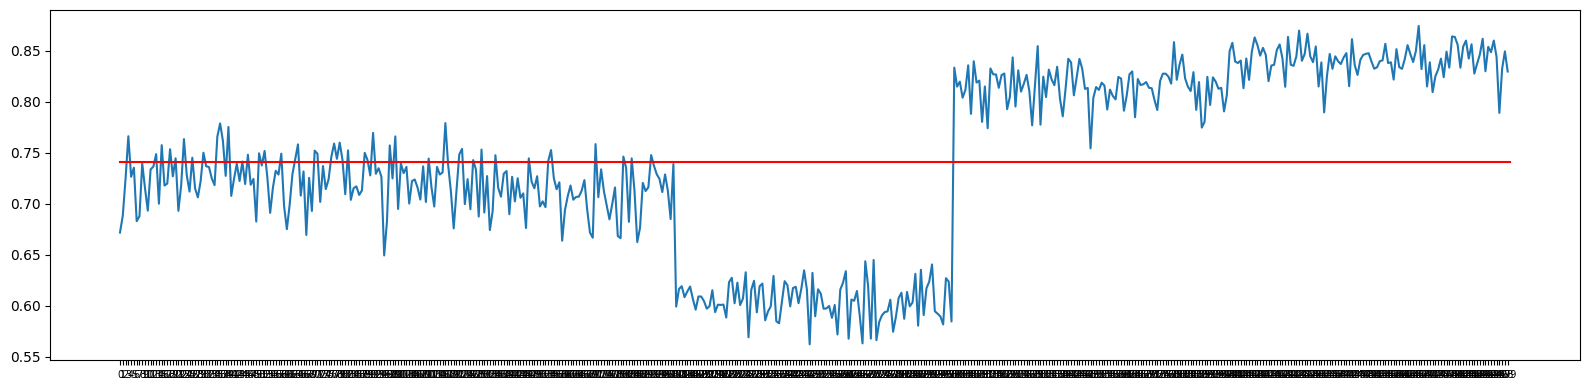

In [16]:
# if you want to check what global random for training testing split is good:
print ('mean of R2', np.mean(r_squareds_global))
plt.subplots(figsize=(16, 4))
#r_squareds_global_mean = np.mean (np.array (r_squareds_global), axis=0)
r_squareds_global_mean = r_squareds_global
plt.plot (list(range(len(r_squareds_global_mean))), 
             r_squareds_global_mean);
xticks = list(range(0, len(r_squareds_global_mean), 1));
plt.plot([0, len(r_squareds_global_mean)], 
         [np.mean(r_squareds_global_mean), 
          np.mean(r_squareds_global_mean)], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)
# what random has the best average for the 5 runs
print ('random of ', np.argmax (r_squareds_global_mean), 
       'with max of: ', np.max (r_squareds_global_mean))

mean of R2 0.7405399920547396
random of  0 with max of:  0.7405399920547396


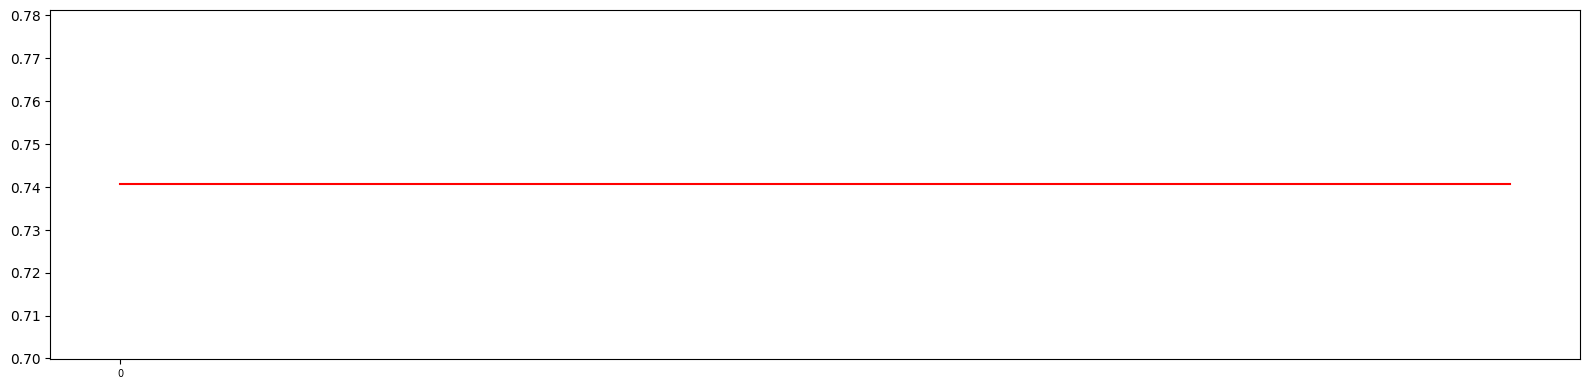

In [17]:
# After fixing global randomness, check random of XGBoost
print ('mean of R2', np.mean(r_squareds_global))
plt.subplots(figsize=(16, 4))
r_squareds_global_mean = np.mean (np.array (r_squareds_global), axis=0)
plt.plot (list(range(len(r_squareds_global_mean))), 
             r_squareds_global_mean);
xticks = list(range(0, len(r_squareds_global_mean), 1));
plt.plot([0, len(r_squareds_global_mean)], 
         [np.mean(r_squareds_global_mean), 
          np.mean(r_squareds_global_mean)], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)
# what random has the best average for the 5 runs
print ('random of ', np.argmax (r_squareds_global_mean), 
       'with max of: ', np.max (r_squareds_global_mean))